--- [Step 1] Installing Libraries ---

--- Libraries Installed ---

--- [Step 2] Downloading Data ---
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: navyanthnyu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mrwellsdavid/unsw-nb15


100%|██████████| 149M/149M [00:00<00:00, 1.13GB/s]


--- Loading Dataframes ---
Training set shape: (82332, 45)
Testing set shape: (175341, 45)
Combined set shape: (257673, 45)

Target Variable Distribution (Before Cleaning):
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64

--- [Step 3] Preprocessing ---
Cleaning target variable 'attack_cat'...

Target Variable Distribution (After Cleaning):
attack_cat
Normal            93000
Generic           58871
Exploits          44525
Fuzzers           24246
DoS               16353
Reconnaissance    13987
Analysis           2677
Backdoor           2329
Shellcode          1511
Worms               174
Name: count, dtype: int64

Dropping identifier columns...
 identified 3 categorical features and 39 numerical features.
Handling missing values and anomalies...
Building ColumnT

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training Complete.

--- [Step 6] Ensemble Evaluation ---
Predicting on Test Set...
Final Accuracy: 0.8246

Classification Report:
                precision    recall  f1-score   support

      Analysis       1.00      0.07      0.14       535
      Backdoor       0.98      0.09      0.17       466
           DoS       0.32      0.10      0.16      3271
      Exploits       0.62      0.88      0.73      8905
       Fuzzers       0.70      0.58      0.63      4849
       Generic       1.00      0.97      0.99     11774
        Normal       0.90      0.95      0.92     18600
Reconnaissance       0.91      0.77      0.84      2798
     Shellcode       0.66      0.61      0.64       302
         Worms       0.57      0.23      0.33        35

      accuracy                           0.82     51535
     macro avg       0.77      0.53      0.55     51535
  weighted avg       0.82      0.82      0.81     51535


Generating Confusion Matrix Plot...


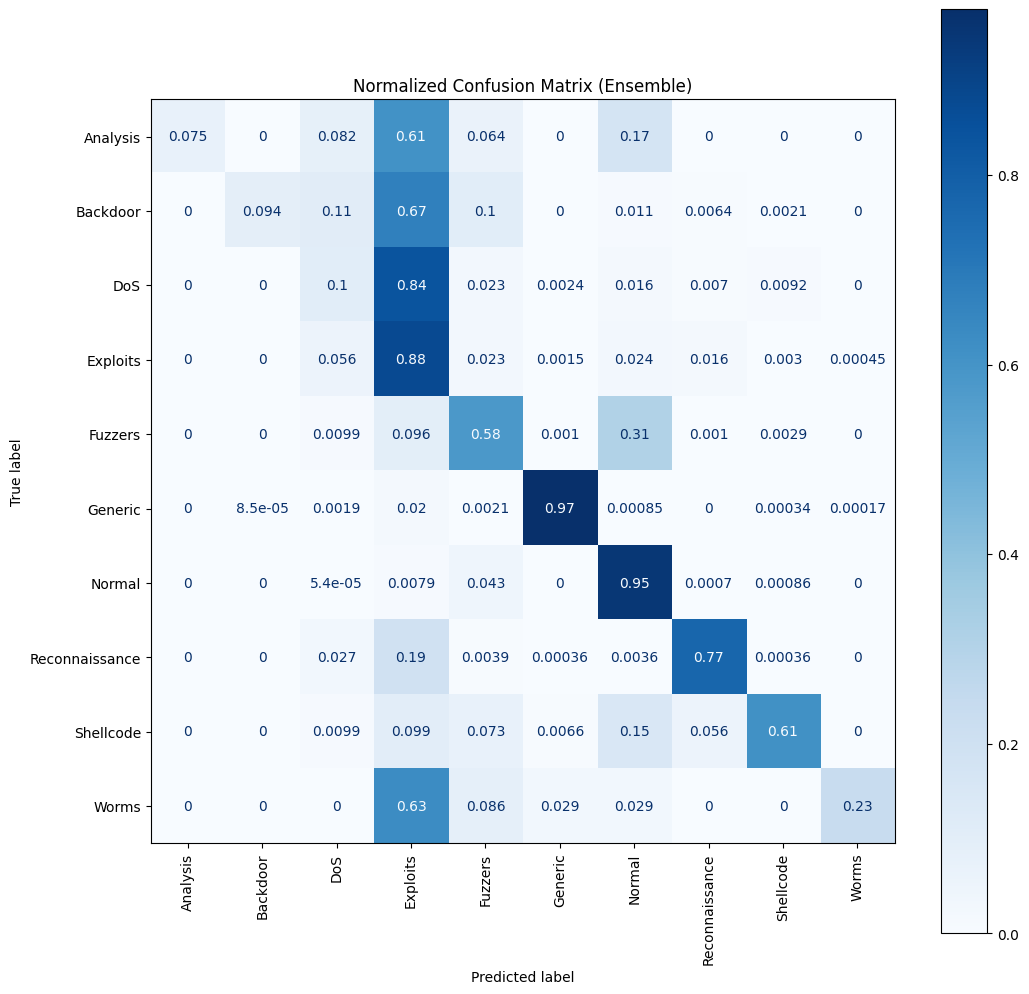


--- [Step 7] Saving Artifacts ---
Serializing Ensemble Model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done! All files downloaded.


In [1]:
# NIRA Advanced: Ensemble Model Training (v5)

# "Voting Ensemble" combining the "Power Trio":

    # 1. XGBoost (Gradient Boosting) - for complex patterns
    # 2. Random Forest (Bagging)     - for stability and noise reduction
    # 3. Logistic Regression (Linear)- for baseline simplicity

# --- 1. Install & Setup ---
print("--- Installing Libraries ---")
!pip install opendatasets --upgrade --quiet
!pip install pandas xgboost joblib scikit-learn==1.6.1 matplotlib seaborn

print("\n--- Libraries Installed ---")

import opendatasets as od
import os
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

# --- 2. Load Data ---
print("\n--- [Step 2] Downloading Data ---")
dataset_id = 'mrwellsdavid/unsw-nb15'
od.download(f'https://www.kaggle.com/datasets/{dataset_id}')
data_dir = './unsw-nb15'
train_file = f'{data_dir}/UNSW_NB15_training-set.csv'
test_file = f'{data_dir}/UNSW_NB15_testing-set.csv'

print("\n--- Loading Dataframes ---")
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)
print(f"Training set shape: {df_train.shape}")
print(f"Testing set shape: {df_test.shape}")

df = pd.concat([df_train, df_test], ignore_index=True)
print(f"Combined set shape: {df.shape}")

# Clean columns
df.columns = df.columns.str.strip()

print("\nTarget Variable Distribution (Before Cleaning):")
print(df['attack_cat'].value_counts(dropna=False))

# --- 3. Preprocessing ---
print("\n--- [Step 3] Preprocessing ---")

# Clean target
print("Cleaning target variable 'attack_cat'...")
df['attack_cat'] = df['attack_cat'].fillna('Normal').str.strip().replace('Backdoors', 'Backdoor')
if 'label' in df.columns: df = df.drop(columns=['label'])

print("\nTarget Variable Distribution (After Cleaning):")
print(df['attack_cat'].value_counts())

# Clean features
print("\nDropping identifier columns...")
drop_features = ['id', 'srcip', 'sport', 'dstip', 'dsport']
df = df.drop(columns=drop_features, errors='ignore')

# Identify columns
cat_features = ['proto', 'service', 'state']
num_features = [col for col in df.columns if col not in cat_features + ['attack_cat']]
print(f" identified {len(cat_features)} categorical features and {len(num_features)} numerical features.")

# Clean data values
print("Handling missing values and anomalies...")
df['service'] = df['service'].str.strip().replace('-', 'none')
for col in num_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[num_features] = df[num_features].fillna(df[num_features].mean())
df[cat_features] = df[cat_features].fillna('unknown').astype(str)

# Build Pipeline
print("Building ColumnTransformer pipeline...")
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ],
    remainder='passthrough'
)

# Encode Y
print("Encoding Target Labels...")
X = df.drop(columns=['attack_cat'])
y_labels = df['attack_cat']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

# Transform X
print("Transforming Feature Data (Scaling & Encoding)...")
X_processed = preprocessor.fit_transform(X)
print(f"Processed Feature Matrix Shape: {X_processed.shape}")

# --- 4. Define The Experts (Models) ---
print("\n--- [Step 4] Initializing Ensemble Models ---")

# Model 1: XGBoost (The "Brain")
clf1 = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
print(" - Model 1: XGBoost initialized.")

# Model 2: Random Forest (The "Senate")
clf2 = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
print(" - Model 2: Random Forest initialized.")

# Model 3: Logistic Regression (The "Baseline")
clf3 = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)
print(" - Model 3: Logistic Regression initialized.")

# --- 5. Build & Train Voting Classifier ---
print("\n--- [Step 5] Training Voting Ensemble (Soft Vote) ---")

print("Professor, This may take 5-10 minutes...")

eclf = VotingClassifier(
    estimators=[
        ('xgb', clf1),
        ('rf', clf2),
        ('lr', clf3)
    ],
    voting='soft'
)

# Split data
print("Splitting data into Training (80%) and Testing (20%) sets...")
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Train!
print("Fitting Ensemble Model...")
eclf.fit(X_train, y_train)
print("Training Complete.")

# --- 6. Evaluation ---
print("\n--- [Step 6] Ensemble Evaluation ---")
print("Predicting on Test Set...")
y_pred = eclf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {acc:.4f}")

print("\nClassification Report:")
target_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nGenerating Confusion Matrix Plot...")


fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_estimator(eclf, X_test, y_test,
                                      display_labels=target_names,
                                      xticks_rotation='vertical',
                                      ax=ax,
                                      normalize='true',
                                      cmap='Blues')
plt.title("Normalized Confusion Matrix (Ensemble)")
plt.show()

# --- 7. Save Artifacts ---
print("\n--- [Step 7] Saving Artifacts ---")
from google.colab import files

# Save the ensemble model using Joblib
print("Serializing Ensemble Model...")
joblib.dump(eclf, 'nira_ensemble_model.joblib')
joblib.dump(preprocessor, 'nira_preprocessor.joblib')
joblib.dump(label_encoder, 'nira_label_encoder.joblib')

# Save feature lists
feature_lists = {
    'num_features': num_features,
    'cat_features': cat_features,
    'drop_features': drop_features
}
joblib.dump(feature_lists, 'nira_feature_lists.joblib')

print("Downloading files...")
files.download('nira_ensemble_model.joblib')
files.download('nira_preprocessor.joblib')
files.download('nira_label_encoder.joblib')
files.download('nira_feature_lists.joblib')

print("Done! All files downloaded.")